In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("Set1")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

# 04 1D Heat transfer (explicit solution) 

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

> This notebook is strongly inspired by the notebooks of the online course _["Practical Numerical Methods with Python"](https://github.com/numerical-mooc/numerical-mooc/) by Lorena A. Barba et al_

## 3D Heat equation
$$
\begin{align}
\frac{\partial T}{\partial t} &=  \nabla\left( \alpha \nabla T \right) + s\\
\frac{\partial T}{\partial t} &= \frac{\partial}{\partial x} \left( \alpha_x  \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( \alpha_y  \frac{\partial T}{\partial y} \right) + \frac{\partial}{\partial z} \left( \alpha_z  \frac{\partial T}{\partial z} \right) + s
\end{align}
$$

Homogeneous $\alpha$:

$$
\begin{align}
\frac{\partial T}{\partial t} &=  \alpha \nabla^2 T + s \\
\frac{\partial T}{\partial t} &= \alpha_x  \frac{\partial^2 T}{\partial x^2} + \alpha_y\frac{\partial^2 T}{\partial y^2} + \alpha_z \frac{\partial^2 T}{\partial z^2} + s(t, x, y, z)
\end{align}
$$


- $T$ - Temperature $[K]$ or $[^\circ C]$
- $t$ - Time $[s]$
- $x, y, z$ - Spatial Position $[m]$
- $\alpha$ - Thermal Diffusivity $\left[ \frac{m^2}{s} \right]$:

$$
\alpha = \frac{k}{\rho c_p}
$$

- $k$ - Thermal Conductivity $\left[ \frac{W}{K \cdot m} \right]$
- $c_p$ - Specific Heat Capacity $\left[ \frac{J}{K \cdot kg} \right]$
- $\rho$ - Density $\left[ \frac{kg}{m^3} \right]$
- $s(t, x, y, z)$ - Source Terme $\left[ \frac{K}{s} \right]$


## 1D case


$$
\frac{\partial T}{\partial t} = \alpha_x \frac{\partial^2 T}{\partial x^2} + s
$$

## Finite Difference Operators

First derivates of $f(x)$ are defined as:

\begin{align}
\frac{\mathrm{d} f(x)}{\mathrm{d} t} = f'(x) &= \frac{x(t + \mathrm{d} t) - x(t)}{\mathrm{d} t}  \\
&= \frac{x(t) - x(t - \mathrm{d} t)}{\mathrm{d} t} \\
&= \frac{x(t + \mathrm{d} t) - x(t - \mathrm{d} t)}{2 \mathrm{d} t} \\
&\text{ with } \mathrm{d} t \rightarrow 0
\end{align}

For the so called _Finite difference_ we replace $\mathrm{d} t$ by $\Delta t > 0$:

The _Forward Finite Difference Operator_ becomes:

$$
f'(x) \approx \frac{x(t + \Delta t) - x(t)}{\Delta t}
$$

The _Backward Finite Difference Operator_ is hence:

$$
f'(x) \approx \frac{x(t) - x(t - \Delta t)}{\Delta t} 
$$

And the _Central Finite Difference Operator_ is:

$$
f'(x) \approx \frac{x(t + \Delta t) - x(t - \Delta t)}{2 \Delta t}
$$

We also need the second derivative, where the _Finite Difference Operator_ is:

$$
f''(x) \approx \frac{x(t + \Delta t) - 2 x(t) + x(t - \Delta t)}{\Delta t^2}
$$

These and also higher order operators can be derived from the Taylor polynoms. See additional material _"[Derive Finite Difference Operators from Taylor Series](99 - Derive Finite Difference Operators from Taylor Series.ipynb)"_ for the derivation. 

## Derive operators for Heat Equation


### Discretize time

We discretice time steps $t^n = t^0 + n \cdot \Delta t$ with $0 \leq n \leq N_t - 1$: 


$$
\begin{matrix}
        & \Delta t     &         &  \Delta t   & & & \\
\bullet & \rightarrow  & \bullet & \rightarrow &\bullet & \dots & \bullet  \\
t^0 &  & t^1 & & t^2 &  & t^{N_t - 1}
\end{matrix}
$$


### Discretize space

We discretice the space in the same manner: $x_i = x_0 + i \cdot \Delta x$ with $0 \leq i \leq N_x - 1$: 


$$
\begin{matrix}
        & \Delta x     &         &  \Delta x   & & & \\
\bullet & \leftrightarrow   & \bullet & \leftrightarrow  &\bullet & \dots & \bullet  \\
x_0 &  & x_1 & & x_2 &  & x_{N_x - 1}
\end{matrix}
$$

### Discretized temperature

So that $T^n_i$ is the Temperature at time step $t^n$ at position $x_i$:

$$
\begin{matrix}
& &\bullet & & \bullet & &  \bullet \\
& \Delta t \uparrow & T^{n+1}_{i-1} & & T^{n+1}_i & & T^{n+1}_{i+1} \\
& &\bullet & & \bullet & &  \bullet \\
& \Delta t \uparrow &T^n_{i-1} & & T^n_i & & T^n_{i+1} \\
& &\bullet & & \bullet & &  \bullet \\
&  &T^{n-1}_{i-1} & & T^{n-1}_i & & T^{n-1}_{i+1} \\
& & & \leftrightarrow &  & \leftrightarrow &  \\
& & & \Delta x &  & \Delta x &  \\
\end{matrix}
$$

### Derive the forward (explicit) Finite Difference Scheme in 1D

The partial differential equation we want to solve:

$$
\frac{\partial T}{\partial t} = \alpha_x \frac{\partial^2 T}{\partial x^2} + s
$$

Approximate first time derivative:

$$
\frac{\partial T}{\partial t} \approx \frac{T^{n+1}_{i} - T^n_{i}}{\triangle t}
$$

Approximate second spatial derivative:

$$
\frac{\partial^2 T}{\partial x^2} \approx \frac{T^n_{i-1} - 2 \cdot T^n_i + T^n_{i+1}}{\triangle x^2}
$$

Putting all together:

$$
\frac{T^{n+1}_{i} - T^n_{i}}{\triangle t} = \alpha_x \frac{T^n_{i-1} - 2 \cdot T^n_{i} + T^n_{i+1}}{\triangle x^2} + s^n_{i}
$$

Solve for $T^{n+1}_{i}$ to calculate next time step:

$$
T^{n+1}_{i} = T^n_{i} + \alpha_x \triangle t  \frac{T^n_{i-1} - 2 \cdot T^n_{i} + T^n_{i+1}}{\triangle x^2} + s^n_{i} \triangle t
$$

### Courant-Friedrichs-Lewy (CFL) stability criterion:

$$
\begin{equation}
\sigma = \alpha \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{equation}
$$

$$
\begin{equation}
 \Delta t  \leq \frac{\Delta x^2}{2 \alpha}
\end{equation}
$$

## Example: Heat transfer in rod (or through mold wall far from edges)

<img src="./figures/heat 1d model 01.png" width="400"/>


- Thickness: 

    - $d = 40mm = 0.04 m$


- Elements: 

    - $N_x = 5$


- Element size: 

    - $\Delta x = \frac{d}{N_x - 1} = \frac{0.04 m}{4} = 0.01 m$


- Thermal diffusivity: 

    - $\alpha_x = 10^{-5} m^2 \cdot s^{-1}$


- Initial condition: 

    - $T^{n=0}_i = 0 ^\circ C$ for all $1 \leq i \leq 3$. 


- Boundary conditions:

    - Left boundary: $T^n_{i=0} = 100 ^\circ C$

    - Right boundary: $T^n_{i=4} = 0 ^\circ C$


\begin{align}
T^{n+1}_{i} &= T^n_{i} + \alpha_x \triangle t  \frac{T^n_{i-1} - 2 \cdot T^n_{i} + T^n_{i+1}}{\triangle x^2} + s^n_{i} \triangle t \\
&= T^n_{i} + \sigma  \left(  T^n_{i-1} - 2 \cdot T^n_{i} + T^n_{i+1} \right) + s^n_{i} \triangle t
\end{align}

In [2]:
d = 40 / 1000
Nx = 5
dx = d / (Nx - 1)
x = np.arange(Nx) * dx

alpha = 1e-5
dt = dx**2 / 2 / alpha
print("limit for numerical stability: dt =", dt, "s")

# try larger and smaller time steps
# dt *= 2
# dt /= 2

print("used time step: dt =", dt, "s")

sigma = alpha * dt / dx**2
T = np.zeros(Nx)
T[0] = 100
n = 0

limit for numerical stability: dt = 5.0 s
used time step: dt = 5.0 s


<IPython.core.display.Javascript object>


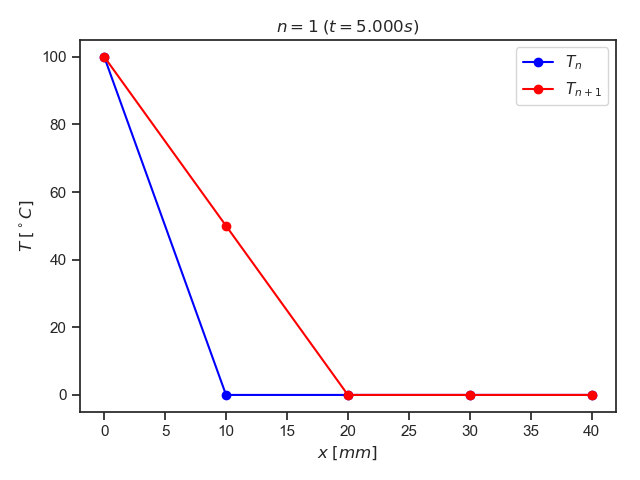

In [3]:
# prepare plot
fig = plt.figure()
plt.ion()

In [4]:
# do one iteration and plot new and old temperature (use CTRL + ENTER to execute cell and stay on cell)
T_old = np.copy(T)
for i in range(1, Nx - 1):
    T[i] = T_old[i] + sigma * (T_old[i-1] - 2*T_old[i] + T_old[i+1])
n += 1
print("time step n =", n)
print("T(n):\t", T_old)
print("T(n+1):\t", T)
plt.gca().cla()
plt.title(r"$n = %d \; (t = %.3f s)$" %(n, n*dt) )
plt.plot(x*1000, T_old, "o-", color="b", label=r"$T_n$")
plt.plot(x*1000, T, "o-", color="r", label=r"$T_{n+1}$")
plt.legend()
plt.xlabel(r"$x \; [mm]$")
plt.ylabel(r"$T \; [^\circ C]$")
plt.tight_layout()
fig.canvas.flush_events()
fig.canvas.draw();

time step n = 1
T(n):	 [100.   0.   0.   0.   0.]
T(n+1):	 [100.  50.   0.   0.   0.]


## Boundary conditions

### Dirichlet boundary

Specify temperature value at boundary for example:

$$
T(x_0, t) = 100 ^\circ C
$$

### Neumann boundary

Specify derivative at boundary:

$$
\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x=d} \approx \frac{T^n_{Nx-1} - T^n_{Nx-2}}{\Delta x} = q(t) \left[ \frac{K}{m} \right]
\end{equation}
$$

$$
\begin{equation}
T^n_{Nx-2} = T^n_{Nx-1} - q(t) \Delta x
\end{equation}
$$

For no heat transfer on boundary $q(t) = 0$:

$$
\begin{equation}
T^n_{Nx-2} = T^n_{Nx-1} 
\end{equation}
$$

<img src="./figures/heat 1d model 02.png" width="400"/>

In [5]:
def explicit1D(T, sigma):
    T[1:-1] = (T[1:-1] +
               sigma * (T[2:] - 2 * T[1:-1] + T[:-2]))
    return T

def explicit1D_nofluxright(T, sigma):
    T[1:-1] = (T[1:-1] +
               sigma * (T[2:] - 2 * T[1:-1] + T[:-2]))
    # no heat flux on right side
    T[-1] = T[-2]
    return T

T = np.zeros(Nx)
T[0] = 100

dt = dx**2 / 2 / alpha
print("limit for numerical stability: dt =", dt, "s")

# try larger and smaller time steps
#dt *= 2
dt /= 4

sigma = alpha * dt / dx**2

print("used time step: dt =", dt, "s")

limit for numerical stability: dt = 5.0 s
used time step: dt = 1.25 s


<IPython.core.display.Javascript object>


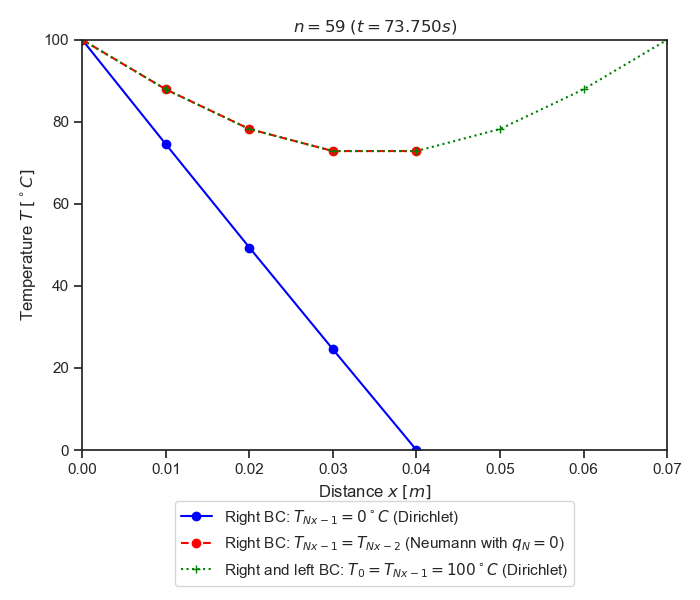

In [7]:
# number of time steps to compute
nt = 60  
# update plots after how many iterations
i_snap = 1

T1 = np.copy(T)
T2 = np.copy(T)

T3 = np.zeros(2*Nx-2)
T3[0] = 100
T3[-1] = 100
x3 = np.arange(2*Nx-2)*dx

fig, ax = plt.subplots(1, 1, figsize=(7.0, 6.0))
plt.ion()
for i in range(nt):    
    T1 = explicit1D(T1, sigma)
    T2 = explicit1D_nofluxright(T2, sigma)
    T3 = explicit1D(T3, sigma)
    
    if i % i_snap == 0:
        ax.cla()
        plt.title(r"$n = %d \; (t = %.3f s)$" %(i, i*dt) )
        plt.xlabel(r'Distance $x \; [m]$')
        plt.ylabel(r'Temperature $T \; [^\circ C]$')
        plt.plot(x, T1, "o-", color="b", 
                 label=r"Right BC: $T_{Nx-1} = 0 ^\circ C$ (Dirichlet)")
        plt.plot(x, T2, "o--", color="r", 
                 label=r"Right BC: $T_{Nx-1} = T_{Nx-2}$ (Neumann with $q_N = 0$)")
        plt.plot(x3, T3, "+:", color="g", 
                 label=r"Right and left BC: $T_{0} = T_{Nx-1} = 100 ^\circ C$ (Dirichlet)")

        plt.autoscale(tight=True)
        plt.tight_layout()
        plt.subplots_adjust(bottom=.25)
        plt.legend(loc="lower center", bbox_to_anchor=[.5, -.35])
        fig.canvas.flush_events()
        fig.canvas.draw()    
        plt.pause(.2);